In [215]:
import sys
import os
import glob
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize, rotate
from skimage import color
from skimage.morphology import closing, opening, disk, square
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
import math 
import numpy as np
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.filters import threshold_otsu
from skimage.util import img_as_bool, img_as_ubyte

# tymczasowe importy do testów
from skimage.measure import find_contours, approximate_polygon, regionprops, label
from skimage.color import label2rgb
from skimage.draw import circle_perimeter, rectangle_perimeter, circle, line
from matplotlib import cm

In [2]:
# do wersji v1
def get_line_length(point1, point2):
    return math.pow((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 , 0.5)
def get_angle_of_line(line):
    (point1, point2) = line
    angle = math.atan2(point2[1] - point1[1], point2[0] - point1[0]) * 180 / np.pi
    return angle #if angle >= 0 else 180+angle

def get_angle_to_rotate_image(image):
    thresh = threshold_otsu(image)
    image_binary = image > thresh
    edges = canny(image_binary, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/3),
                                     line_gap=10)

    counter_of_tries = 0
    while lines == 0 and counter_of_tries < 3:
        edges = canny(image_binary, sigma=1, low_threshold=False, high_threshold=True)
        min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
        lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/3),
                                         line_gap=10)

    longest_line = (lines[0],  get_line_length(lines[0][0], lines[0][1]))
    for line in lines:
        temp_lenght = get_line_length(line[0], line[1])
        if temp_lenght > longest_line[1]:
            longest_line = (line, temp_lenght)

    angle = get_angle_of_line(longest_line[0])
    baseline = longest_line[0]
    return angle, baseline

def compare_2_numbers_with_range(n1, n2, range=3):
    difference = abs(n1-n2)
    return difference <= range
compare_2_numbers_with_range(5.40, 3.10, 3)

def compare_2_points_with_range(point1, point2, range=3):
    x1, y1 = point1
    x2, y2 = point2
    return compare_2_numbers_with_range(x1, x2, range) and compare_2_numbers_with_range(y1, y2, range)
compare_2_points_with_range((10,20), (8,27), 5)

False

In [175]:
def check_if_perpendicular_lines(line1, line2, accuracy_in_degrees=10):
    point11, point12 = line1
    point21, point22 = line2
#     print("line1: ",line1 )
#     print("line2: ",line2 )
    if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
        angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
#         print(angle_between_lines)
        if compare_2_numbers_with_range(angle_between_lines, 90, accuracy_in_degrees) or compare_2_numbers_with_range(angle_between_lines, 270, accuracy_in_degrees):
            return True
    return False

# def check_if_parallel_lines(line1, line2, accuracy_in_degrees=10):
#     point11, point12 = line1
#     point21, point22 = line2
#     if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
#         angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
#         if compare_2_numbers_with_range(angle_between_lines, 0, accuracy_in_degrees) or compare_2_numbers_with_range(angle_between_lines, 360, accuracy_in_degrees):
#             return True  
#     return False


In [405]:
# do wersji v3 - szukanie punktów skrajnych
# def get_extreme_points(image):
#     possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
#     minHeight = image.shape[0]-1
#     maxHeight = 0 
#     minWidth = image.shape[1]-1 
#     maxWidth = 0 
#     for height, width in possible_baseline_points:
#         if height <= minHeight:
#             minHeight = height
#         if width <= minWidth:
#             minWidth = width
            
#         if height >= maxHeight:
#             maxHeight = height
#         if width >= maxWidth:
#             maxWidth = width
            
#     extreme_points = set()
#     image = color.grey2rgb(image)
#     for height, width in detected_points:  
#         if height == minHeight or height == maxHeight or width == minWidth or width == maxWidth:
#             rr, cc = circle_perimeter(int(height),int(width), 3)
#             image[rr, cc] = [255,0,0]
#             extreme_points.add((height, width))
        
#     return image, extreme_points


def clamp(n, smallest, largest): 
    return max(smallest, min(n, largest))

def slice_image_in_radius(image, point, radius):
    (height, width) = point
    height = int(height)
    width = int(width)
    (image_height, image_width) = image.shape
    

    point_height_in_sliced_image = radius+1
    point_width_in_sliced_image = radius+1
    if height-radius < 0 :
        point_height_in_sliced_image = radius - (radius-height)
    if width-radius < 0:
        point_width_in_sliced_image = radius - (radius-width)
    middle_point = (point_height_in_sliced_image, point_width_in_sliced_image)

    right_width_min = clamp(width-radius-1, 0, image_width)
    right_width_max = clamp(width+radius+1, 0, image_width)
    right_height_min = clamp(height-radius-1, 0, image_height)
    right_height_max = clamp(height+radius+1, 0, image_height)
    slice_of_image = image[right_height_min:right_height_max, right_width_min:right_width_max]
    return slice_of_image, middle_point

def get_list_of_different_angles_in_image_using_hough(image, radius):
    edges = canny(slice)
    lines = probabilistic_hough_line(edges, 
                                     threshold=10, 
                                     line_length=10,
                                     line_gap=1)
    list_of_angles = [get_angle_of_line(line) for line in lines]
    
    # np. kąty -176 i 180 są obok siebie, zależą od zwrotu, to samo z kątem 90
    # tutaj usuwamy takie przypadki, żeby mieć na penwo różne kąty
    exists_90 = False
    exists_180 = False
    modified_list_of_angles = list()
    for angle in list_of_angles:
        if compare_2_numbers_with_range(90, abs(angle), 10):
            if exists_90 == False:
                exists_90 = True
                modified_list_of_angles.append(angle)
        elif compare_2_numbers_with_range(180, abs(angle), 10):
            if exists_180 == False:
                exists_180 = True
                modified_list_of_angles.append(angle)
        else:
            modified_list_of_angles.append(angle)
    
    return modified_list_of_angles

def get_list_of_different_angles_in_image(image, positions_of_white_pixels, radius, middle_point):
    list_of_angles = list()
    image = color.gray2rgb(image)
    image[middle_point] = (255,0,0)
    for white_point in positions_of_white_pixels:
        add = True
        if get_line_length(middle_point, white_point) > 10:
            point_angle = get_angle_of_line((middle_point, white_point))
            for angle in list_of_angles:
                if compare_2_numbers_with_range(point_angle, angle, 20):
                    add = False
            if add:
                image[white_point] = (255,0,0)
                list_of_angles.append(point_angle)
                
    # np. kąty -176 i 180 są obok siebie, zależą od zwrotu, to samo z kątem 90
    # tutaj usuwamy takie przypadki, żeby mieć na penwo różne kąty
    exists_90 = False
    exists_180 = False
    modified_list_of_angles = list()
    for angle in list_of_angles:
        if compare_2_numbers_with_range(90, abs(angle), 10):
            if exists_90 == False:
                exists_90 = True
                modified_list_of_angles.append(angle)
        elif compare_2_numbers_with_range(180, abs(angle), 10):
            if exists_180 == False:
                exists_180 = True
                modified_list_of_angles.append(angle)
        else:
            modified_list_of_angles.append(angle)
        
    return modified_list_of_angles, image

def check_if_it_is_right_angle_using_angles_of_lines(image, point, radius=10):
    precision_of_angles_of_points = 3
    slice_of_image, middle_point = slice_image_in_radius(image, point, radius)
    
    edges = canny(slice_of_image)
    positions_of_white_pixels = np.where(edges==True)
    positions_of_white_pixels = list(zip(positions_of_white_pixels[0],positions_of_white_pixels[1]))
    
    list_of_angles, slice_of_image = get_list_of_different_angles_in_image(slice_of_image, positions_of_white_pixels, radius, middle_point)
#     print("list_of_angles: ", list_of_angles)
    # jeżeli mamy tylko 1 kąt na wycinku obrazu to powinien składać się z 2 linii, 
    # te 2 linie powinny być pod zupełnie innymi kątami (różnią się o 90 stopni jeżeli prosty)
    # dlatego musimy mieć tylko 2 różne kąty pod jakimi przebiegają te dwie linie
    if len(list_of_angles) == 2:
        n_of_pixels = 3 # liczba pixeli, której szukamy aby zidentyfikować jedną linię
        
        first_list_points_in_one_line = list()
        for white_point in positions_of_white_pixels:
            if get_line_length(middle_point, white_point) > radius/2:
                angle_of_line = get_angle_of_line((middle_point, white_point))
                if compare_2_numbers_with_range(angle_of_line, list_of_angles[0], precision_of_angles_of_points):
                    first_list_points_in_one_line.append(white_point)


        second_list_points_in_one_line = list()
        for white_point in positions_of_white_pixels:
            if get_line_length(middle_point, white_point) > radius/2:
                angle_of_line = get_angle_of_line((middle_point, white_point))
                if compare_2_numbers_with_range(angle_of_line, list_of_angles[1], precision_of_angles_of_points):
                    second_list_points_in_one_line.append(white_point)

#         print("=========================")
#         print("first_list_points_in_one_line: ", first_list_points_in_one_line)
#         print("second_list_points_in_one_line: ", second_list_points_in_one_line)
        
        first_furthest_point = find_furthest_point_in_list(middle_point, first_list_points_in_one_line)
        second_furthest_point = find_furthest_point_in_list(middle_point, second_list_points_in_one_line)
        if len(first_list_points_in_one_line) >= n_of_pixels and len(second_list_points_in_one_line) >= n_of_pixels:               
            if check_if_perpendicular_lines((middle_point,first_furthest_point),
                                            (middle_point,second_furthest_point),
                                           accuracy_in_degrees=12):
                return True

    return False
    
def find_furthest_point_in_list(point, list_of_points):
    max_dist = get_line_length(point, list_of_points[0])
    max_point = list_of_points[0]
    for p in list_of_points[1:]:
        temp_dist = get_line_length(point, p)
        if temp_dist > max_dist:
            max_dist = temp_dist
            max_point = p
    return max_point
    
def get_points_with_right_angle_using_angles_of_lines(image):
    possible_baseline_points = corner_peaks(corner_harris(image), min_distance=10)
    points_with_right_angle = set()
#     print("possible_baseline_points: ", possible_baseline_points)
    for c in possible_baseline_points:
        if check_if_it_is_right_angle_using_hough(image=image, point=(c[0],c[1]), radius=20):
            points_with_right_angle.add((c[0],c[1]))
    
    return points_with_right_angle

def check_if_it_is_right_angle_using_areas_of_neighborhood(image, point, radius=5, accuracy=0.04):
    slice_of_image, middle_point = slice_image_in_radius(image, point, radius)
    
    thresh = threshold_otsu(slice_of_image)
#     thresh = 127
    slice_of_image_binary = slice_of_image > thresh
    labeled = label(slice_of_image_binary)

    props = regionprops(labeled)
    white_area = props[0].area
    black_area = (radius*2+1)**2-white_area
    
    white_to_black_ratio = white_area/(white_area+black_area)
#     print("white_to_black_ratio: ", white_to_black_ratio)
    return True if compare_2_numbers_with_range(0.27, white_to_black_ratio, accuracy) else False


def get_points_with_right_angle_using_areas_of_neighborhood(image):
    possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
    points_with_right_angle = set()
    for c in possible_baseline_points:
        if check_if_it_is_right_angle_using_areas_of_neighborhood(image=image, point=(c[0],c[1]), radius=30):
            points_with_right_angle.add((c[0],c[1]))
    
    return points_with_right_angle

In [73]:
def rotate_image(image, angle, baseline):
    baseline = [(el[1],el[0]) for el in baseline]
    is_baseline_top = True
    is_baseline_left = True
    
    (image_height, image_width) = image.shape
    (base_point1, base_point2) = baseline
    
    baseline_avg_height = (base_point1[0]+base_point2[0])/2
    baseline_avg_width = (base_point1[1]+base_point2[1])/2
    if baseline_avg_height <= image_height/2:
        is_baseline_top = True
    else:
        is_baseline_top = False
        
    if baseline_avg_width <= image_width/2:
        is_baseline_left = True
    else:
        is_baseline_left = False
        
    if angle >= 0:
        if not is_baseline_left:
            return img_as_bool(rotate(image, 180+angle, resize=True))
        else:
            return img_as_bool(rotate(image, angle, resize=True))

    if angle < 0:
        if is_baseline_left:
            return img_as_bool(rotate(image, 180+angle, resize=True))
        else:
            return img_as_bool(rotate(image, angle, resize=True))
    

def max_height_and_width_from_images(images):
    max_height, max_width = images[0].shape
    for image in images:
        if image.shape[0] > max_height:
            max_height = image.shape[0]
        if image.shape[1] > max_width:
            max_width = image.shape[1]
    return max_height, max_width

def min_height_and_width_from_images(images):
    min_height, min_width = images[0].shape
    for image in images:
        if image.shape[0] < min_height:
            min_height = image.shape[0]
        if image.shape[1] < min_width:
            min_width = image.shape[1]
    return min_height, min_width

def resize_image(image, max_height, max_width):  
    scale = max_width/image.shape[1]
    new_shape = (int(image.shape[0]*scale), int(image.shape[1]*scale))
    image_resized = (resize(img_as_ubyte(image), new_shape))
    image_resized = threshold_image(image_resized)
    
    return image_resized



def cut_image_sides(image):
    label_img, num = label(image, connectivity=2, return_num=True, background=0)
    region_props = regionprops(label_img)
    biggest_region = region_props[0]
    for region in region_props:
        if region.area > biggest_region.area:
            biggest_region = region
    image_cut = image[biggest_region.bbox[0]-2:biggest_region.bbox[2],biggest_region.bbox[1]:biggest_region.bbox[3]+1]
    return image_cut

def threshold_image(image):
    thresh = threshold_otsu(image)
    thresholded = image > thresh
#     cleared = clear_border(thresholded)
    return thresholded

def open_close_image(image):
    image = opening(closing(image, disk(2)), disk(2))
    


    # jeżeli wyższy niż szerszy to obróć
    if image.shape[1] < image.shape[0]:
        image = img_as_bool(rotate(image, 90, resize=True))
        
    first_row = image[0, :]
    unique_values, counts = np.unique(first_row, return_counts=True)
    unique_counts_dict = dict(zip(unique_values, counts))
    white_pixel_count = 0
    black_pixel_count = 0
        
    # dodatkowe sprawdzenie czy nie jest do góry nogami
    if False in unique_counts_dict:
        black_pixel_count = unique_counts_dict[False]
    if True in unique_counts_dict:
        white_pixel_count = unique_counts_dict[True]
    
#     print(white_pixel_count/(white_pixel_count + black_pixel_count))
#     print("==============================")
    if white_pixel_count/(white_pixel_count + black_pixel_count) > 0.8:
        image = img_as_bool(rotate(image, 180, resize=True))
    return image

In [404]:
# wersja używa najdłuższej linii w figurze jako podstawy, nie zawsze będzie działało dla późniejszych przykałdów
def rotate_scale_and_cut_image_v1(image, image_path, max_height, max_width):
    image = threshold_image(image)
    angle, baseline = get_angle_to_rotate_image(image)
    image = rotate_image(image, angle, baseline)
    image = cut_image_sides(image)
    image = resize_image(image, max_height, max_width)
    image = open_close_image(image)
    return image

# wersja wycina kawałki na około wykrytych punktów i na tej podstawie szuka katów prostych i podstawy
def rotate_scale_and_cut_image_v3(image, image_path, max_height, max_width):
    image = add_black_border_to_image(image)
    image = threshold_image(image)
    points_using_angles_of_lines = get_points_with_right_angle_using_angles_of_lines(image)
    points_using_areas_of_neighborhood = get_points_with_right_angle_using_areas_of_neighborhood(image)
    
#     print("=======")
#     print(points_using_angles_of_lines)
#     print(points_using_areas_of_neighborhood)
#     print("=======")
    baseline = list(points_using_angles_of_lines.intersection(points_using_areas_of_neighborhood))
    baseline = [(el[1],el[0]) for el in baseline]
#     print("baseline: ", baseline)
    if len(baseline) != 2:
        baseline = None
    if baseline == None:
        print('Nie znaleziono podstawy dla obrazka z użyciem v3: {0}'.format(image_path))
        return rotate_scale_and_cut_image_v1(image, image_path, max_height, max_width) #todo
#         return image
#     print("baseline: ", baseline)
    angle = get_angle_of_line(baseline)
    image = rotate_image(image, angle, baseline) 
    image = cut_image_sides(image)
    image = resize_image(image, max_height, max_width)
    image = open_close_image(image)
    return image

asdaf
line1:  ((21, 21), (16, 1))
line2:  ((21, 21), (40, 19))
98.02723751043197
tak
True


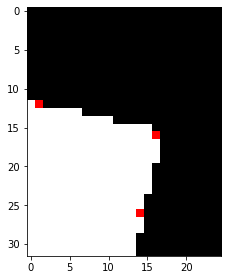

In [174]:
# sprawdzanie wycinku w kącie
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1', '')
images_paths = glob.glob(os.path.join(path, '*.png'))
images = [io.imread(image_path) for image_path in images_paths]
image = io.imread("D:\\Dokumenty\\Projekty\\PIRO\\project1\\proj1_daneA\\set5\\28.png")
image = threshold_image(image)

print(check_if_it_is_right_angle_using_angles_of_lines(image, (38, 208), radius=20))
io.imshow(img_as_ubyte(slice))

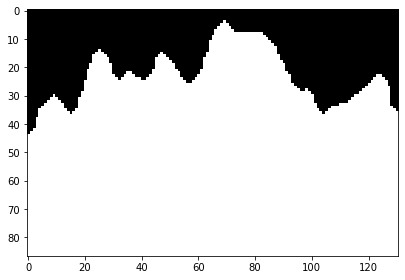

In [413]:
n_of_cases = 5
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set0', '')
images_paths = glob.glob(os.path.join(path, '*.png'))
images = [io.imread(image_path) for image_path in images_paths]

max_height, max_width = min_height_and_width_from_images(images)
img = io.imread("D:\\Dokumenty\\Projekty\\PIRO\\project1\\proj1_daneA\\set1\\14.png")

img = rotate_scale_and_cut_image_v3(img, images_paths[1], max_height, max_width)
# print(corner_peaks(corner_harris(img), min_distance=1))
# img = color.gray2rgb(img)
# for angle in appr_pol:
#     rr, cc = circle(angle[0],angle[1], 3)
#     img[rr, cc] = [255,0,0]
# img[64, 69] = (255,0,0)
# img[269, 163] = (255,0,0)
io.imshow(img)

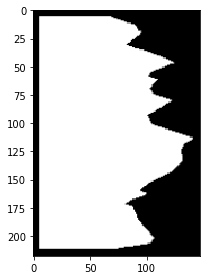

In [310]:
img = io.imread("D:\\Dokumenty\\Projekty\\PIRO\\project1\\proj1_daneA\\set1\\14.png")
io.imshow(img)

In [414]:
# teścik
from pathlib import Path
n_of_sets = 7
for n in range(n_of_sets):
    set_source_path = "./proj1_daneA/set"+ str(n)
    set_result_path = "./proj1_daneA_wyniki/set"+ str(n)
    Path(set_result_path).mkdir(parents=True, exist_ok=True)

    images_paths = glob.glob(os.path.join(set_source_path, '*.png'))
    images = [io.imread(image_path) for image_path in images_paths]
    min_height, min_width = min_height_and_width_from_images(images)
    processed_images = list()
    for i, image in enumerate(images):
        _, filename = os.path.split(images_paths[i])
        
        processed_image = rotate_scale_and_cut_image_v3(image, images_paths[i], min_height, min_width)

        save_path = os.path.join(os.path.join(set_result_path, filename))
        io.imsave(save_path, arr=img_as_ubyte(processed_image))


n_of_sets = 2
for n in range(7, n_of_sets+7):
    set_source_path = "./proj1_daneB/set"+ str(n)
    set_result_path = "./proj1_daneB_wyniki/set"+ str(n)
    Path(set_result_path).mkdir(parents=True, exist_ok=True)

    images_paths = glob.glob(os.path.join(set_source_path, '*.png'))
    images = [io.imread(image_path) for image_path in images_paths]
    min_height, min_width = min_height_and_width_from_images(images)
    processed_images = list()
    for i, image in enumerate(images):
        _, filename = os.path.split(images_paths[i])
        
        processed_image = rotate_scale_and_cut_image_v3(image, images_paths[i], min_height, min_width)

        save_path = os.path.join(os.path.join(set_result_path, filename))
        io.imsave(save_path, arr=img_as_ubyte(processed_image))


# fig = plt.figure(figsize=(50,20))
# columns = 5
# rows = (len(test_set)/columns)+1
# for i, img in enumerate(processed_images):
#     fig.add_subplot(rows, columns, i+1)
#     plt.imshow(img, cmap=plt.cm.gray)


Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set1\3.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set1\7.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set2\10.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set2\13.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set2\2.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set2\7.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set2\8.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set3\1.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set3\11.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set3\4.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set3\8.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set4\14.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set4\3.png
Nie znaleziono podsta

Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\31.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\32.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\33.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\44.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\49.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\56.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\57.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\6.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\63.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\64.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\71.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\72.png
Nie znaleziono podstawy dla obrazka z użyciem v3: ./proj1_daneA/set6\74.png
Nie znalezion

IndexError: list index out of range

In [62]:
processed_images[8][10,:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

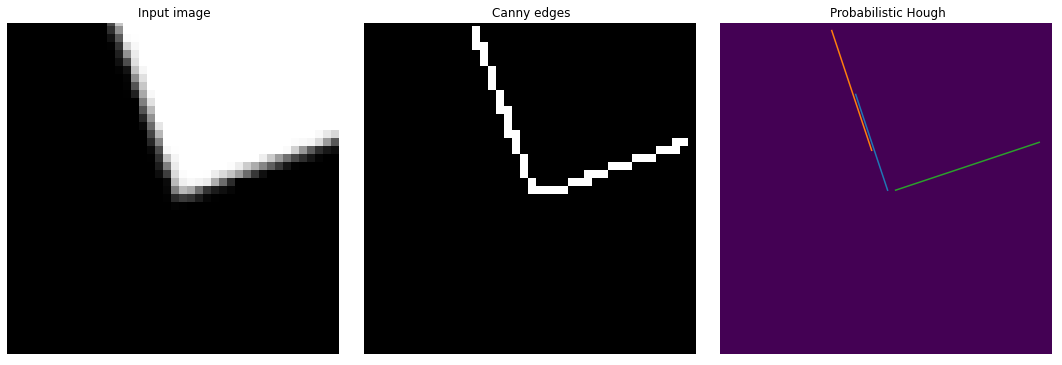

[((21, 21), (17, 9)), ((19, 16), (14, 1)), ((22, 21), (40, 15))]
(((22, 21), (40, 15)), 18.973665961010276)


In [244]:
# image = io.imread(images_paths[106])
image = color.rgb2gray(im)
image, _ = slice_image_in_radius(image, (315.75212263, 107.31450833), 20)
edges = canny(image)
lines = probabilistic_hough_line(edges, threshold=10, line_length=10, line_gap=1)
# longest_line = (lines[0],  get_line_length(lines[0][0], lines[0][1]))
# for line in lines:
#     temp_lenght = get_line_length(line[0], line[1])
#     if temp_lenght > longest_line[1]:
#         longest_line = (line, temp_lenght)
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')


ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
print(lines)
print(longest_line)

In [ ]:
##############################################################
####V4

In [108]:
# wersja wycina kawałki na około wykrytych punktów i na tej podstawie szuka katów prostych i podstawy
def rotate_scale_and_cut_image_v4(image, image_path, max_height, max_width):
    points_using_angles_of_lines = get_points_with_right_angle_using_angles_of_lines(image)
    points_using_areas_of_neighborhood = get_points_with_right_angle_using_areas_of_neighborhood(image)

    baseline = get_baseline_using_corners_order(image, image_path)
    if baseline is not None:
        baseline = [(el[1],el[0]) for el in baseline] 
    else:
        print("Nie znaleziono podstawy używając kolejności kątów dla obrazu: {0}".format(image_path))
        baseline = list(points_using_angles_of_lines.intersection(points_using_areas_of_neighborhood))
        baseline = [(el[1],el[0]) for el in baseline]  
    if len(baseline) != 2:
        baseline = None
    if baseline == None:
        print('Nie znaleziono podstawy dla obrazka z użyciem v3: {0}'.format(image_path))
        return rotate_scale_and_cut_image_v1(image, image_path, max_height, max_width) #todo
    
    angle = get_angle_of_line(baseline)
    image = rotate_image(image, angle, baseline)
    image = cut_image_sides(image)
    image = resize_image(image, max_height, max_width)
    image = open_close_image(image)
    return image

In [ ]:
images_paths

In [111]:
from skimage.segmentation import clear_border
from skimage.feature import corner_harris, corner_subpix, corner_peaks


n=2
im = images[n]

def get_baseline_using_corners_order(image, image_path):
    contour = find_contours(image, level=10)[0]
    appr_pol = list(approximate_polygon(contour, tolerance=5)[:-1])    
    appr_pol = np.around(np.array(appr_pol))
    appr_pol = corner_subpix(image, appr_pol, window_size=20)
    appr_pol = appr_pol[~np.isnan(appr_pol).any(axis=1)]
    appr_pol = list(appr_pol)
    appr_pol_looped = appr_pol+appr_pol[:2]
    angles = list()
    for p1,p2,p3 in zip(appr_pol_looped[:-2], appr_pol_looped[1:-1], appr_pol_looped[2:]):
        line1 = (p1, p2)
        line2 = (p2, p3)
#         print("=======")
#         print(line1)
#         print(line2)
        if check_if_perpendicular_lines(line1, line2, accuracy_in_degrees=5):
            angles.append(np.array([p1, p2, p3]))
#     print("angles")
#     print(np.array(angles))
    right_angles = list()
    for angle in angles:
        if check_if_it_is_right_angle_using_areas_of_neighborhood(image, angle[1], radius=30, accuracy=0.04):
            right_angles.append(angle)
#     print("right_angles")
#     print(np.array(right_angles))
    if len(right_angles) == 2:
        right_angles_in_baseline = right_angles
        baseline = (right_angles_in_baseline[0][1], right_angles_in_baseline[1][1])
        return baseline
    elif len(right_angles) > 2:
        right_angles.append(right_angles[0])
        right_angles_in_baseline = list()
        for p1, p2 in zip(right_angles[:-1], right_angles[1:]):
            for p11, p22 in zip(appr_pol_looped[:-1], appr_pol_looped[1:]):
                if p1[1][0] == p11[0] and p1[1][1] == p11[1] and p2[1][0] == p22[0] and p2[1][1] == p22[1]:
                    right_angles_in_baseline.append(p1)
                    right_angles_in_baseline.append(p2)
        
        if len(right_angles_in_baseline) == 2:
            baseline = (right_angles_in_baseline[0][1], right_angles_in_baseline[1][1])
            return baseline
        else:
#             print("Nie znaleziono podstawy używając kolejności kątów dla obrazu: {0}".format(image_path))
            return None
    return None

baseline = get_baseline_using_corners_order(im, 'image_path')

im = color.gray2rgb(im)
baseline = np.array(baseline)
print(baseline)
for angle in baseline:
    print(angle)
    rr, cc = circle(angle[0],angle[1], 3)
    im[rr, cc] = [255,0,0]
# for angle in baseline[:,2]:
#     print(angle)
#     rr, cc = circle(angle[0],angle[1], 3)
#     im[rr, cc] = [255,0,0]

# for angle in baseline[:,0]:
#     print(angle)
#     rr, cc = circle(angle[0],angle[1], 3)
#     im[rr, cc] = [255,0,0]


# print(images_paths[n])
# print(len(angles))
# for angle in appr_pol:
#     print(angle)
#     rr, cc = circle(angle[0],angle[1], 3)
#     im[rr, cc] = [255,0,0]
# io.imshow(im)
# for im in images:
#     result = get_baseline_using_corners_order(im, 'image_path')
#     if result is not None:
#         print(result)
io.imshow(im)

None


TypeError: iteration over a 0-d array

In [ ]:
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set0', '')
images_paths = glob.glob(os.path.join(path, '*.png'))
images = [io.imread(image_path) for image_path in images_paths]
images = images
fig = plt.figure(figsize=(50,50))
columns = 5
rows = (len(images)/columns)+1
for i,im in enumerate(images):
    
    contour = find_contours(im, level=10)[0]
    appr_pol = find_corners(im)
    im = color.gray2rgb(im)
#     print(len(appr_pol))
    for angle in appr_pol:
    #     print(angle)
        rr, cc = circle(angle[0],angle[1], 3)
        im[rr, cc] = [255,0,0]
        
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(im, cmap=plt.cm.gray)
    

[[  5   5]
 [ 19  94]
 [ 30  84]
 [ 46 123]
 [ 58 103]
 [ 61 109]
 [ 69 104]
 [ 80 121]
 [ 93 102]
 [113 141]
 [159  96]
 [162  99]
 [171  83]
 [174  87]
 [201 106]
 [205 104]
 [211   5]]


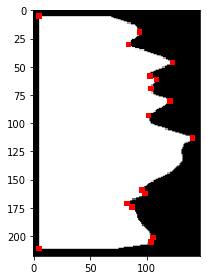

In [327]:
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1', '')
images_paths = glob.glob(os.path.join(path, '*.png'))
images = [io.imread(image_path) for image_path in images_paths]

im = io.imread("D:\\Dokumenty\\Projekty\\PIRO\\project1\\proj1_daneA\\set1\\14.png")
# im = add_black_border_to_image(im, 15)
contour = find_contours(im, level=10)[0]
appr_pol = find_corners(im)
im = color.gray2rgb(im)
#     print(len(appr_pol))
for angle in appr_pol:
#     print(angle)
    rr, cc = circle(angle[0],angle[1], 3)
    im[rr, cc] = [255,0,0]

io.imshow(im)

In [410]:
def get_list_of_different_angles_in_image_using_hough(image, radius):
    edges = canny(image)
    lines = probabilistic_hough_line(edges, 
                                     threshold=10, 
                                     line_length=10,
                                     line_gap=1)
    list_of_angles = [get_angle_of_line(line) for line in lines]
    list_of_angles_no_duplicates = list()
#     print(len(lines))
    
    for angle in list_of_angles:
        add = True
        for added_angle in list_of_angles_no_duplicates:
            if compare_2_numbers_with_range(added_angle, angle, 5):
                add = False
        if add:
            list_of_angles_no_duplicates.append(angle)
                
    # np. kąty -176 i 180 są obok siebie, zależą od zwrotu, to samo z kątem 90
    # tutaj usuwamy takie przypadki, żeby mieć na penwo różne kąty
    exists_90 = False
    exists_180 = False
    modified_list_of_angles = list()
    for angle in list_of_angles_no_duplicates:
        if compare_2_numbers_with_range(90, abs(angle), 10):
            if exists_90 == False:
                exists_90 = True
                modified_list_of_angles.append(angle)
        elif compare_2_numbers_with_range(180, abs(angle), 10):
            if exists_180 == False:
                exists_180 = True
                modified_list_of_angles.append(angle)
        else:
            modified_list_of_angles.append(angle)
    
    return modified_list_of_angles, edges

def check_if_it_is_right_angle_using_hough(image, point, radius=10):
    slice_of_image, _ = slice_image_in_radius(image, point, radius)
    list_of_angles, edges = get_list_of_different_angles_in_image_using_hough(image=slice_of_image, radius=20)
#     print("point: ", point)
#     print("list_of_angles: ", list_of_angles)
#     print("len list_of_angles: ", len(list_of_angles))
#     print("type list_of_angles: ", type(list_of_angles))
    if len(list_of_angles) == 2 and (compare_2_numbers_with_range(90, abs(list_of_angles[0]-list_of_angles[1]), range=10) or compare_2_numbers_with_range(270, abs(list_of_angles[0]-list_of_angles[1]), range=10)) :
#         print("TRUE")
#         print("=================")
        return True
    else:
#         print("FALSE")
#         print("=================")
        return False

img = io.imread("D:\\Dokumenty\\Projekty\\PIRO\\project1\\proj1_daneA\\set1\\14.png")
f, edges = check_if_it_is_right_angle_using_hough(img, (149, 245), radius=20)
# # im = color.rgb2gray(im)
# # slice, _ = slice_image_in_radius(im, (315.75212263, 107.31450833), 20)
# # angles = get_list_of_different_angles_in_image_using_hough(image=im, radius=20)
# # print(angles)
io.imshow(img)

ValueError: The parameter `image` cannot be an empty array

In [326]:
def find_corners(image):
#     contour = find_contours(im, level=10)[0]
#     appr_pol = np.around(np.array(list(approximate_polygon(contour, tolerance=5)[:-1])))
# #     appr_pol_looped = appr_pol+appr_pol[:2]
# #     coners_peaks = corner_peaks(corner_harris(image), min_distance=5)
#     coords_subpix = corner_subpix(image, appr_pol, window_size=13)
    
    contour = find_contours(image, level=10)[0]
#     appr_pol = list(approximate_polygon(contour, tolerance=5)[:-1]) 
    appr_pol = corner_peaks(corner_harris(image), min_distance=1)
#     appr_pol_looped = appr_pol+appr_pol[:2]
#     appr_pol = np.around(np.array(appr_pol))
#     appr_pol = corner_subpix(image, appr_pol, window_size=20)
#     appr_pol = appr_pol[~np.isnan(appr_pol).any(axis=1)]
#     appr_pol = list(appr_pol)
#     appr_pol_looped = appr_pol+appr_pol[:2]
    print(np.array(appr_pol))
    return appr_pol

In [191]:
def add_black_border_to_image(image, width_of_border=30):
    (h, w) = image.shape
    new_image_left_border = np.zeros((h,w+width_of_border))
    new_image_left_border[:,width_of_border:] = image
    image = new_image_left_border
    
    (h, w) = image.shape
    new_image_right_border = np.zeros((h,w+width_of_border))
    new_image_right_border[:,:-width_of_border] = image
    image = new_image_right_border
    
    (h, w) = image.shape
    new_image_bot_border = np.zeros((h+width_of_border,w))
    new_image_bot_border[:-width_of_border,:] = image
    image = new_image_bot_border
    
    (h, w) = image.shape
    new_image_top_border = np.zeros((h+width_of_border,w))
    new_image_top_border[width_of_border:,:] = image
    image = new_image_top_border
    return image

In [ ]:
g = images[3]
b = np.zeros((g.shape[0],g.shape[1]+10))
b[:,:-10] = g
io.imshow(b)

In [ ]:
io.imshow(g)

In [ ]:
img = add_black_border_to_image(images[3], 30)

In [355]:
line = ((3,5),(3,7))
get_angle_of_line(line)

90.0